# INTRODUCTION

We have data from patients diagnosed with GBM and their course of treatment and survival.

In [42]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from plotnine import *
import statsmodels.api as sm
from statsmodels.formula.api import ols

np.random.seed(123) #ensure reproducibility

#ignore errors about using jupyter notebook or sample size being too small
import warnings
warnings.simplefilter("ignore", UserWarning) 

In [43]:
mpl.rcParams.update({'errorbar.capsize': 5})

# styles from: https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')
# plt.style.use('ggplot')
# plt.style.use('fivethirtyeight')
# plt.style.use('default')

sns.set_style("whitegrid")
sns.set(font_scale=1.4)

In [44]:
df = pd.read_csv('GBM_clean.csv')

In [333]:
print(df['sex'].count(), 'GBM patients gathered')
print(df['sex'].dropna().count(), 'with no missing records')

304 GBM patients gathered
304 with no missing records


In [177]:
df = df.dropna()

In [45]:
df.head()

,sex,diagnosis_age,days_survived,dead,treatment,tumor_side,tumor_location,idh_status,mgmt_mean,ps_preop,ps_postop,sx_duration,chemo,radiotherapy,sx_main,alive_6months,alive_12months,alive_18months
0,male,67,3,1,Biopsy,left,Thalamus,0,NaN,2.0,NaN,10.0,0,0,deficit,0,0,0
1,male,66,5,1,Biopsy,left,Insula,0,NaN,1.0,4.0,91.0,0,0,seizure,0,0,0
2,male,61,5,1,Biopsy,left,Insula,0,NaN,0.0,NaN,14.0,0,0,headache,0,0,0
3,male,64,7,1,Gross Total Resection,right,Frontal lobe,0,64.0,1.0,NaN,28.0,0,0,deficit,0,0,0
4,male,27,8,1,Biopsy,right,Parietal lobe,0,NaN,4.0,4.0,56.0,0,0,deficit,0,0,0


In [46]:
df.describe()

,diagnosis_age,days_survived,dead,idh_status,mgmt_mean,ps_preop,ps_postop,sx_duration,chemo,radiotherapy,alive_6months,alive_12months,alive_18months
count,489.000000,489.000000,489.000000,489.000000,464.000000,429.000000,403.000000,421.000000,489.000000,489.000000,489.000000,489.000000,489.000000
mean,61.695297,295.971370,0.781186,0.028630,19.221185,0.857809,1.255583,39.072447,0.486708,36.216769,0.588957,0.290389,0.141104
std,11.328696,267.392477,0.413866,0.166935,20.322172,0.862411,0.998351,76.353829,0.500335,25.386400,0.492527,0.454407,0.348486
min,18.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,107.000000,1.000000,0.000000,4.000000,0.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,63.000000,224.000000,1.000000,0.000000,6.800000,1.000000,1.000000,14.000000,0.000000,40.000000,1.000000,0.000000,0.000000
75%,70.000000,384.000000,1.000000,0.000000,35.000000,1.000000,2.000000,42.000000,1.000000,60.000000,1.000000,1.000000,0.000000
max,84.000000,1585.000000,1.000000,1.000000,93.000000,4.000000,4.000000,730.000000,1.000000,60.000000,1.000000,1.000000,1.000000


It's a clean and easy to understand set of data. However, the meaning of some of the column headers are not obvious:

* **sex**
* **diagnosis_age** = Age at Diagnosis
* **days_survived** = How many days they survived from diagnosis
* **dead**
  * 1 = dead
  * 0 = alive
* **treatment**
  * biopsy
  * debulking
  * subtotal resection
  * gross total resection
* **tumor_side**
* **tumor_location**
* **idh_status** = IDH-1 Status
  * 1 = positive
  * 0 = negative
* **mgmt_mean** = Mean MGMT level (value >10 significant in Addenbrooke's)
* **ps_preop** = Performance status pre-op
* **ps_postop** = Performance status post-op
* **sx_duration** = Duration of symptoms prior to presentation in days
* **sx_main** = main symptom prior to presentation
  * Neurological deficit
  * headache
  * seizure
* **Chemo** = 0 = none, 1 = TMZ (all having 60GY RT will have chemo)
* **radiotherapy**
  * 0 = none 
  * 30gy 
  * 40gy
  * 60gy

In [66]:
df2 = df.copy()
df2['alive_6months'] = df2['alive_6months'].replace([0,1], ['dead', 'alive'])
df2['alive_12months'] = df2['alive_12months'].replace([0,1], ['dead', 'alive'])
df2['alive_18months'] = df2['alive_18months'].replace([0,1], ['dead', 'alive'])

In [67]:
df2.groupby('alive_12months').mean()

,diagnosis_age,days_survived,dead,idh_status,mgmt_mean,ps_preop,ps_postop,sx_duration,chemo,radiotherapy
alive_12months,,,,,,,,,,
alive,56.205882,624.137255,0.627451,0.068627,20.886863,0.598039,0.725490,37.524510,0.872549,55.490196
dead,63.554455,175.133663,0.846535,0.014851,18.949158,0.881188,1.311881,32.084158,0.391089,33.168317


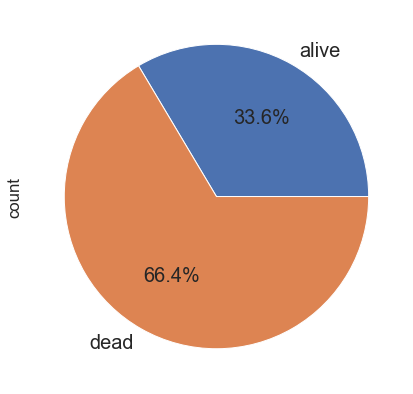

In [68]:
fig = df2.groupby('alive_12months')['diagnosis_age'].describe()['count'].plot(kind='pie', 
                                                            figsize=(7,7), 
                                                            autopct='%1.1f%%', 
                                                            textprops={'fontsize': 20})
plt.show()

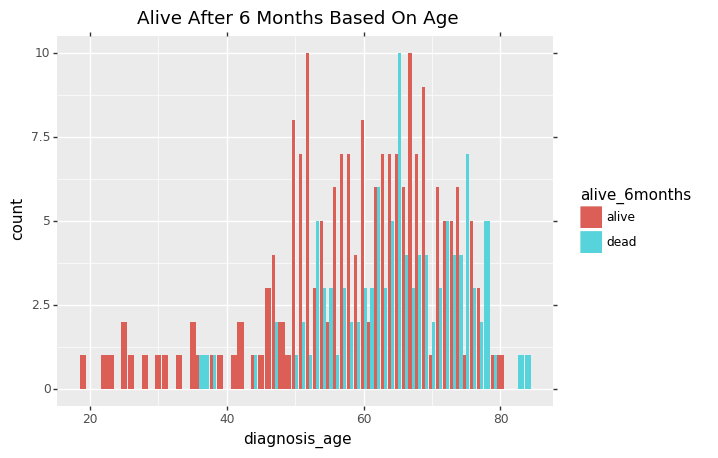

In [69]:
fig = (ggplot(df2, aes(x='diagnosis_age', fill='alive_6months'))
       + geom_bar(position='dodge')
       + labs(title='Alive After 6 Months Based On Age')
      ).draw()
fig.show()

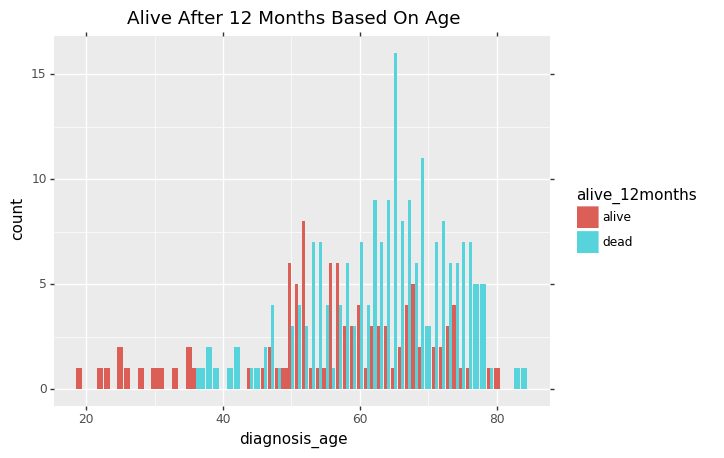

In [70]:
fig = (ggplot(df2, aes(x='diagnosis_age', fill='alive_12months'))
       + geom_bar(position='dodge')
       + labs(title='Alive After 12 Months Based On Age')
      ).draw()
fig.show()

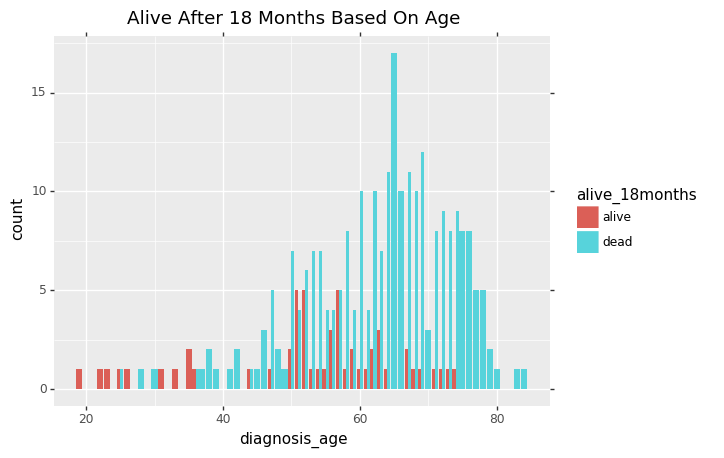

In [71]:
fig = (ggplot(df2, aes(x='diagnosis_age', fill='alive_18months'))
       + geom_bar(position='dodge')
       + labs(title='Alive After 18 Months Based On Age')
      ).draw()
fig.show()

In [72]:
age = df2['diagnosis_age'].describe()
age_range = age['max'] - age['min']
age_range

65.0

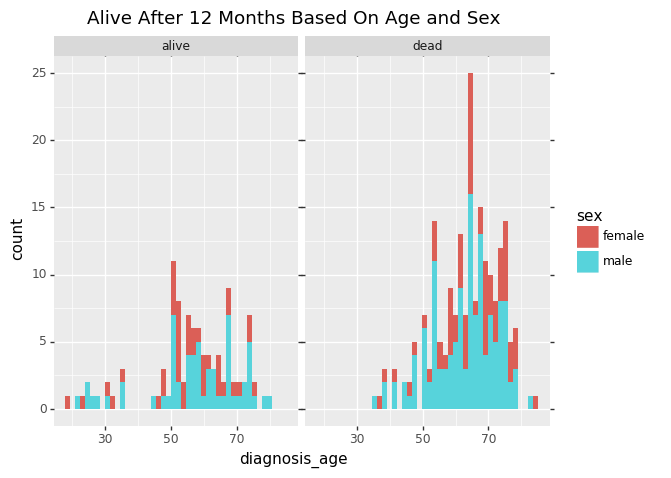

In [73]:
fig = (ggplot(df2, aes(x='diagnosis_age', fill='sex'))
       + geom_histogram(bins=age_range/1.5)
       + facet_grid('~ alive_12months')
       + labs(title='Alive After 12 Months Based On Age and Sex')
      ).draw()
fig.show()

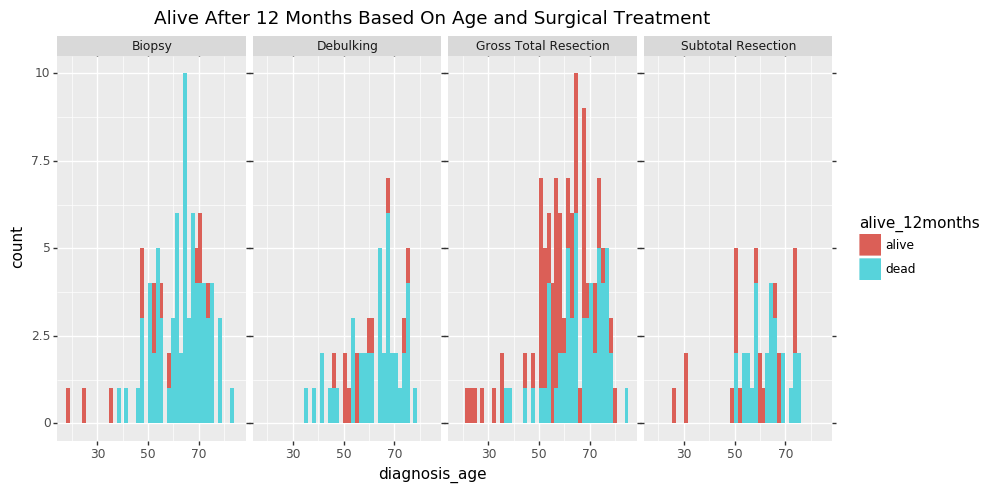

In [98]:
fig = (ggplot(df2, aes(x='diagnosis_age', fill='alive_12months'))
       + geom_histogram(bins=age_range/1.5)
       + facet_grid('~ treatment')
       + theme(figure_size=(10,5))
       + labs(title='Alive After 12 Months Based On Age and Surgical Treatment')
      ).draw()
fig.show()

In [80]:
df2.groupby('tumor_location')['alive_12months'].describe()

,count,unique,top,freq
tumor_location,,,,
Cerebellum,3,2,dead,2
Corpus callosum,5,1,dead,5
External capsule,4,2,dead,3
Frontal lobe,90,2,dead,56
Insula,4,1,dead,4
Occipital lobe,17,2,dead,11
Parietal lobe,64,2,dead,41
Temporal lobe,112,2,dead,75
Thalamus,5,1,dead,5


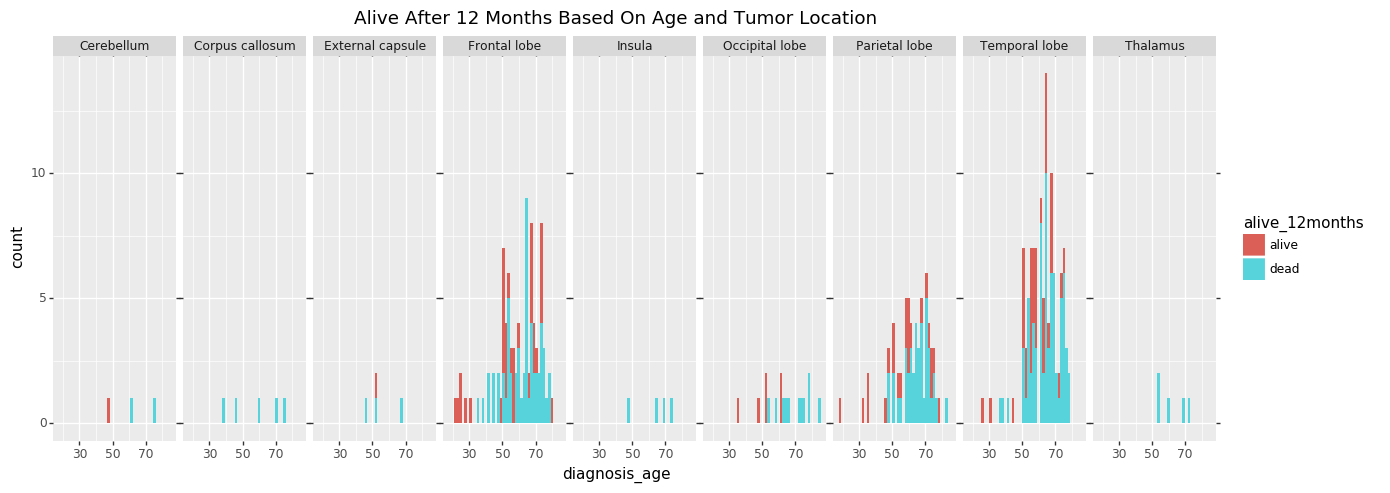

In [75]:
fig = (ggplot(df2, aes(x='diagnosis_age', fill='alive_12months'))
       + geom_histogram(bins=age_range/1.5)
       + facet_grid('~ tumor_location')
       + theme(figure_size=(15,5))
       + labs(title='Alive After 12 Months Based On Age and Tumor Location')
      ).draw()
fig.show()

In [79]:
df2.groupby('sx_main')['alive_12months'].describe()

,count,unique,top,freq
sx_main,,,,
deficit,190,2,dead,141
headache,58,2,dead,30
seizure,56,2,dead,31


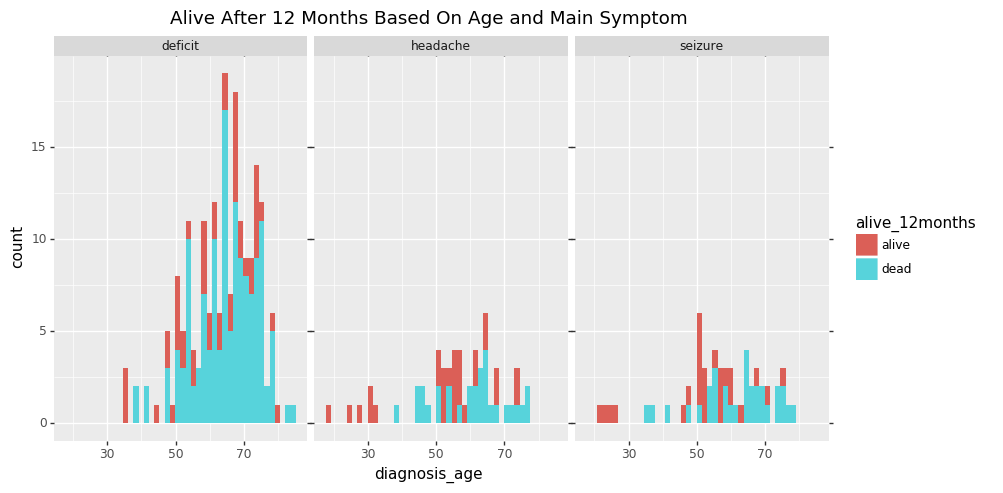

In [78]:
fig = (ggplot(df2, aes(x='diagnosis_age', fill='alive_12months'))
       + geom_histogram(bins=age_range/1.5)
       + facet_grid('~ sx_main')
       + theme(figure_size=(10,5))
       + labs(title='Alive After 12 Months Based On Age and Main Symptom')
      ).draw()
fig.show()

In [94]:
df2.groupby('radiotherapy')['alive_12months'].describe()

,count,unique,top,freq
radiotherapy,,,,
0,60,2,dead,56
30,64,2,dead,60
40,18,2,dead,13
60,162,2,alive,89


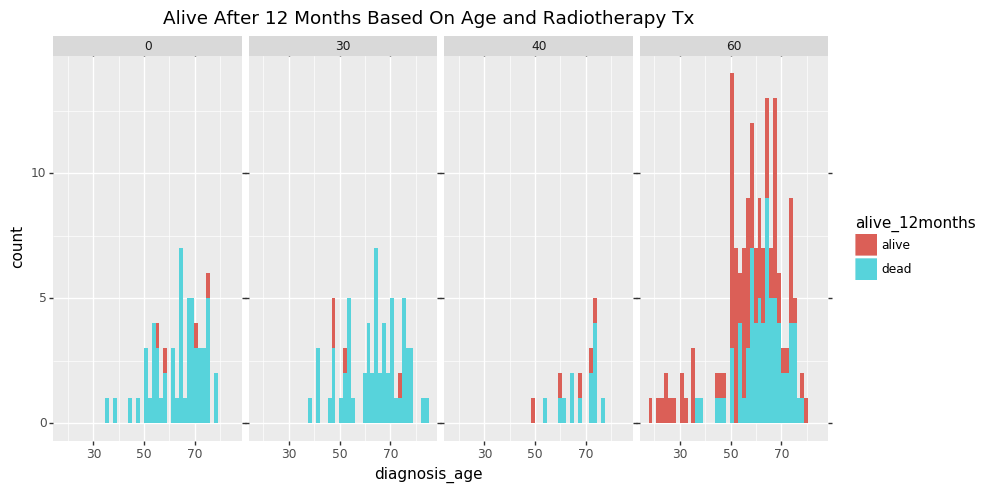

In [100]:
fig = (ggplot(df2, aes(x='diagnosis_age', fill='alive_12months'))
       + geom_histogram(bins=age_range/1.5)
       + facet_grid('~ radiotherapy')
       + theme(figure_size=(10,5))
       + labs(title='Alive After 12 Months Based On Age and Radiotherapy Tx')
      ).draw()
fig.show()

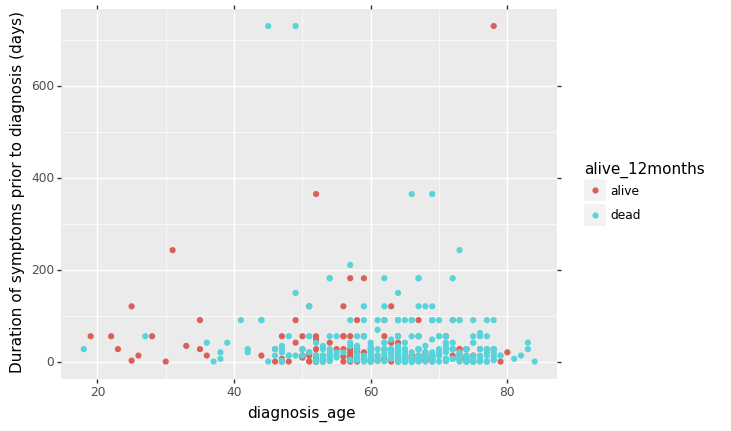

In [34]:
fig = (ggplot(df2, aes(x='diagnosis_age', y='sx_duration', colour='alive_12months'))
       + geom_point()
       + labs(y='Duration of symptoms prior to diagnosis (days)')
      ).draw()
fig.show()

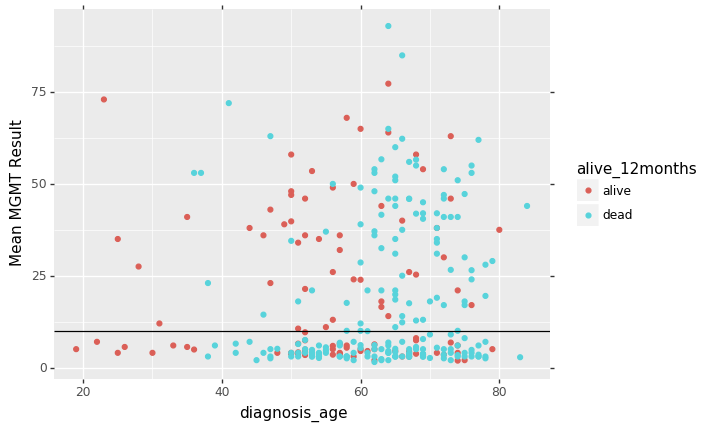

In [93]:
fig = (ggplot(df2, aes(x='diagnosis_age', y='mgmt_mean', colour='alive_12months'))
       + geom_point()
       + geom_hline(yintercept=[10])
       + labs(y='Mean MGMT Result')
      ).draw()
fig.show()

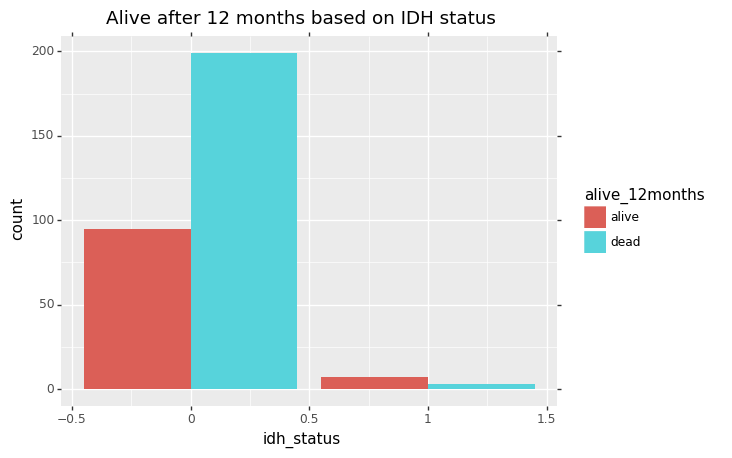

In [104]:
fig = (ggplot(df2, aes(x='idh_status', fill='alive_12months'))
       + geom_bar(position='dodge')
       + labs(title='Alive after 12 months based on IDH status')
      ).draw()
fig.show()

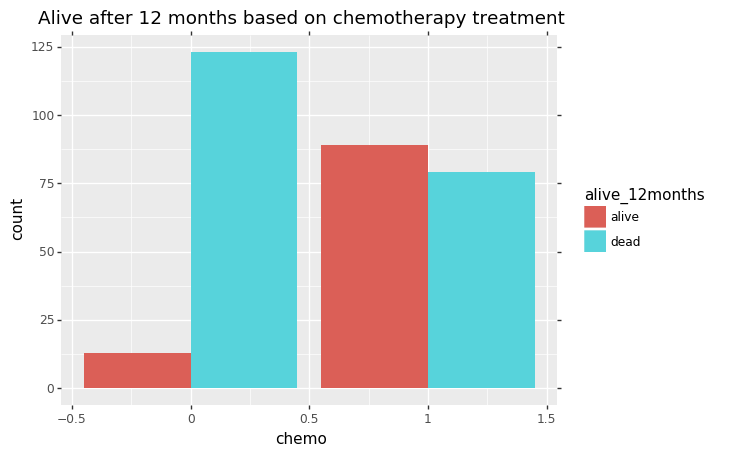

In [106]:
fig = (ggplot(df2, aes(x='chemo', fill='alive_12months'))
       + geom_bar(position='dodge')
       + labs(title='Alive after 12 months based on chemotherapy treatment')
      ).draw()
fig.show()

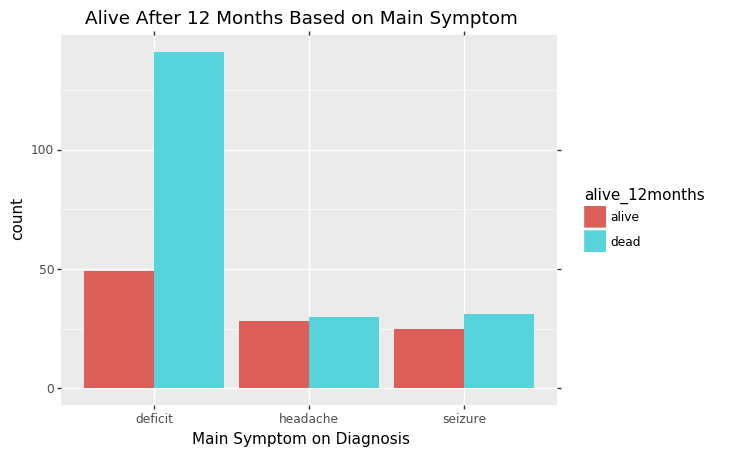

In [108]:
fig = (ggplot(df2, aes(x='sx_main', fill='alive_12months'))
       + geom_bar(position='dodge')
       + labs(title='Alive After 12 Months Based on Main Symptom', x='Main Symptom on Diagnosis')
      ).draw()
fig.show()

# Introduction to Logistic Regression
Logistic regression models are used to analyze the relationship between a dependent variable (DV) and independent variable(s) (IV) when the DV is dichotomous. The DV is the outcome variable, a.k.a. the predicted variable, and the IV(s) are the variables that are believed to have an influence on the outcome, a.k.a. predictor variables. If the model contains 1 IV, then it is a simple logistic regression model, and if the model contains 2+ IVs, then it is a multiple logistic regression model.

Assumptions for logistic regression models:

* The DV is categorical (binary)
  * If there are more than 2 categories in terms of types of outcome, a multinomial logistic regression should be used
* Independence of observations
  * Cannot be a repeated measures design, i.e. collecting outcomes at two different time points.
* Independent variables are linearly related to the log odds
* Absence of multicollinearity
* Lack of outliers

The DV is `alive_12months` (does the patient survive >12 months) and the IVs are all the variables:

In [114]:
df2.columns.to_list()

['sex',
 'diagnosis_age',
 'days_survived',
 'dead',
 'treatment',
 'tumor_side',
 'tumor_location',
 'idh_status',
 'mgmt_mean',
 'ps_preop',
 'ps_postop',
 'sx_duration',
 'chemo',
 'radiotherapy',
 'sx_main',
 'alive_6months',
 'alive_12months',
 'alive_18months']

In [121]:
print(df['sex'].count(), 'GBM patients gathered')
print(df['sex'].dropna().count(), 'with no missing records')

489 GBM patients gathered
304 with no missing records


In [126]:
df.dropna()[['days_survived','alive_6months', 'alive_12months', 'alive_18months']].describe()

,days_survived,alive_6months,alive_12months,alive_18months
count,304.000000,304.000000,304.000000,304.000000
mean,325.786184,0.631579,0.335526,0.177632
std,270.231420,0.483172,0.472953,0.382832
min,11.000000,0.000000,0.000000,0.000000
25%,133.000000,0.000000,0.000000,0.000000
50%,256.500000,1.000000,0.000000,0.000000
75%,442.250000,1.000000,1.000000,0.000000
max,1585.000000,1.000000,1.000000,1.000000


Looking at the descriptive statistics, of the 102 patients, 33% of the patients survived more than 12 months.

One thing to keep in mind is that there are several variables that are truly categorical, which we have previously converted from their integer representation to strings. We will need to convert these data types to accurately be included in our model. This can be done with the helper function `pd.get_dummies()`. It automatically creates a new variable for each category type of the original variable and codes new dummy variables where 1 is membership to that category and 0 is non-membership.

In [127]:
df.dtypes

sex                object
diagnosis_age       int64
days_survived       int64
dead                int64
treatment          object
tumor_side         object
tumor_location     object
idh_status          int64
mgmt_mean         float64
ps_preop          float64
ps_postop         float64
sx_duration       float64
chemo               int64
radiotherapy        int64
sx_main            object
alive_6months       int64
alive_12months      int64
alive_18months      int64
dtype: object

In [150]:
categorical = [
    'treatment',
    'tumor_side',
    'tumor_location',
    'sx_main',
    'radiotherapy',
    'ps_preop',
    'ps_postop'
]
df_cat = df.copy().dropna()
for category in categorical:
    df_cat[category] = df_cat[category].astype('category')
df_cat.dtypes

sex                 object
diagnosis_age        int64
days_survived        int64
dead                 int64
treatment         category
tumor_side        category
tumor_location    category
idh_status           int64
mgmt_mean          float64
ps_preop          category
ps_postop         category
sx_duration        float64
chemo                int64
radiotherapy      category
sx_main           category
alive_6months        int64
alive_12months       int64
alive_18months       int64
dtype: object

In [151]:
df_cat = pd.get_dummies(df_cat)
df_cat.columns.to_list()

['diagnosis_age',
 'days_survived',
 'dead',
 'idh_status',
 'mgmt_mean',
 'sx_duration',
 'chemo',
 'alive_6months',
 'alive_12months',
 'alive_18months',
 'sex_female',
 'sex_male',
 'treatment_Biopsy',
 'treatment_Debulking',
 'treatment_Gross Total Resection',
 'treatment_Subtotal Resection',
 'tumor_side_Both',
 'tumor_side_left',
 'tumor_side_right',
 'tumor_location_Cerebellum',
 'tumor_location_Corpus callosum',
 'tumor_location_External capsule',
 'tumor_location_Frontal lobe',
 'tumor_location_Insula',
 'tumor_location_Occipital lobe',
 'tumor_location_Parietal lobe',
 'tumor_location_Temporal lobe',
 'tumor_location_Thalamus',
 'ps_preop_0.0',
 'ps_preop_1.0',
 'ps_preop_2.0',
 'ps_preop_3.0',
 'ps_preop_4.0',
 'ps_postop_0.0',
 'ps_postop_1.0',
 'ps_postop_2.0',
 'ps_postop_3.0',
 'ps_postop_4.0',
 'radiotherapy_0',
 'radiotherapy_30',
 'radiotherapy_40',
 'radiotherapy_60',
 'sx_main_deficit',
 'sx_main_headache',
 'sx_main_seizure']

In [ ]:
df_cat.columns = [x.lower().replace(' ', '_') for x in df_cat.columns]

## Multiple Logistic Regression Checks
First the assumptions of the model need to be checked. We already know that (1) **DV is categorical** (target - binary), and (2) we know there is **independence of observations** (different patients).

Let's check the rest of the assumptions!

### Assumption of continuous IVs being linearly related to the log odds
Logistic regression does not require the continuous IV(s) to be linearly related to the DV. It does require the continuous IV(s) be linearly related to the log odds of the IV though. A way to test this is to plot the IV(s) in question and look for an S-shaped curve. Sometimes the S-shape will not be obvious. The plot should have a flat or flat-ish top and bottom with an increase or decreasing middle.

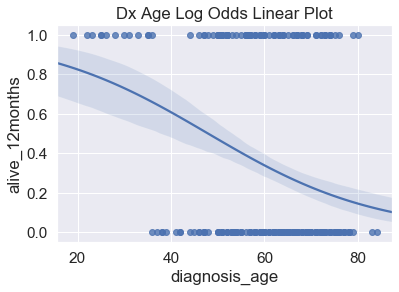

In [131]:
g = sns.regplot(x='diagnosis_age', 
                y='alive_12months', 
                data= df_cat, logistic= True)
g.set_title("Dx Age Log Odds Linear Plot")
plt.show()

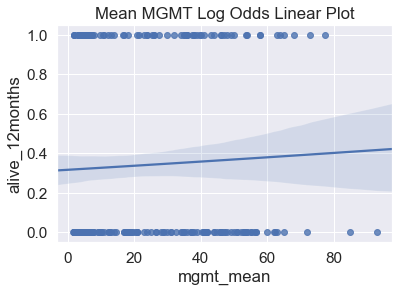

In [134]:
g = sns.regplot(x='mgmt_mean', 
                y='alive_12months', 
                data= df_cat, logistic= True)
g.set_title("Mean MGMT Log Odds Linear Plot")
plt.show()

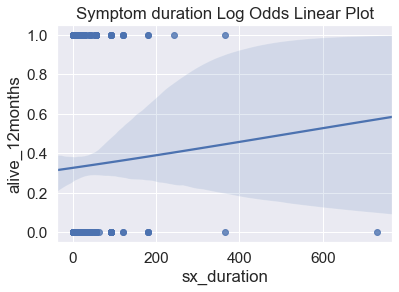

In [135]:
g = sns.regplot(x='sx_duration', 
                y='alive_12months', 
                data= df_cat, logistic= True)
g.set_title("Symptom duration Log Odds Linear Plot")
plt.show()

As you can see the `mgmt_mean` and `sx_duration` are not linearly related to the log odds of IV and should be dropped from the model, as it will only add unneeded noise.

### Assumption of Absence of Multicollinearity
An easy way to test this is to use a correlation matrix, and look for any highly correlated variables, and/or to look at for high Variance Inflation Factor (VIF) scores. If there are variables that are highly correlated, or have a high VIF, a corrective action would be to drop one of them since they are measuring the same/similar thing.

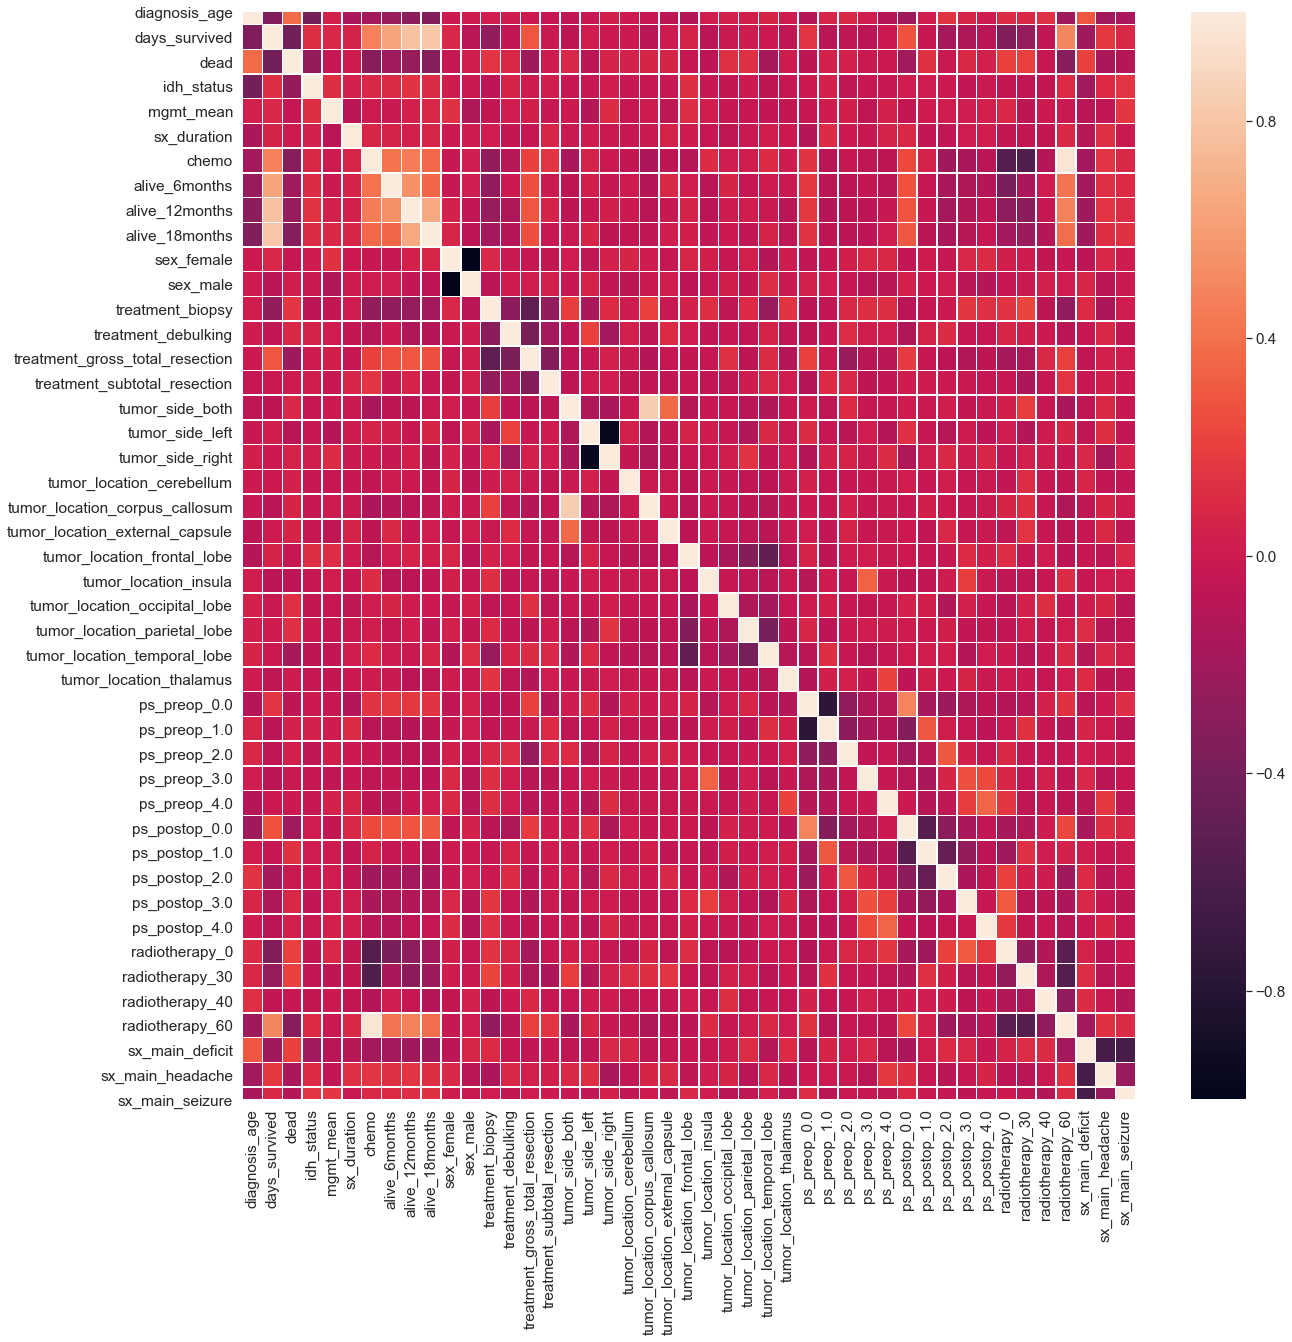

In [157]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df_cat.corr(), linewidths=.5,
#             annot=True, fmt=".2f", annot_kws={"size": 12}, 
            ax=ax)
fig.show()

The only independent variables that have a moderate correlation with staying alive is `treatment_gross_total_resection`, `chemotherapy `, `radiotherapy`. 

However, as you can see there are several variables with multicollinearity such as `days_survived` and the other categories `alive_{x}months`, we will need to remove these variables from our final model.

### Assumption of Lack of Outliers
The assumption of lack of outliers is an easy one to check. One can get a feel of this with the descriptive statistics provided by the `.describe()` method. The easiest way to check for outliers is to use a box plot.

In [158]:
numerical = [
    'diagnosis_age',
    'mgmt_mean',
    'sx_duration'
]
pd.DataFrame(df2.groupby('alive_12months')[numerical].describe()).T

alive_12months            alive        dead
diagnosis_age count  102.000000  202.000000
              mean    56.205882   63.554455
              std     13.615904    9.796918
              min     19.000000   36.000000
              25%     51.000000   58.000000
              50%     57.000000   65.000000
              75%     66.750000   71.000000
              max     80.000000   84.000000
mgmt_mean     count  102.000000  202.000000
              mean    20.886863   18.949158
              std     20.391234   20.234621
              min      1.880000    1.500000
              25%      4.350000    3.600000
              50%      8.800000    6.775000
              75%     36.000000   34.875000
              max     77.300000   93.000000
sx_duration   count  102.000000  202.000000
              mean    37.524510   32.084158
              std     53.814514   64.281779
              min      0.500000    0.000000
              25%      7.000000    7.000000
              50%     21.000000   14.000000
              75%     56.000000   28.000000
              max    365.000000  730.000000

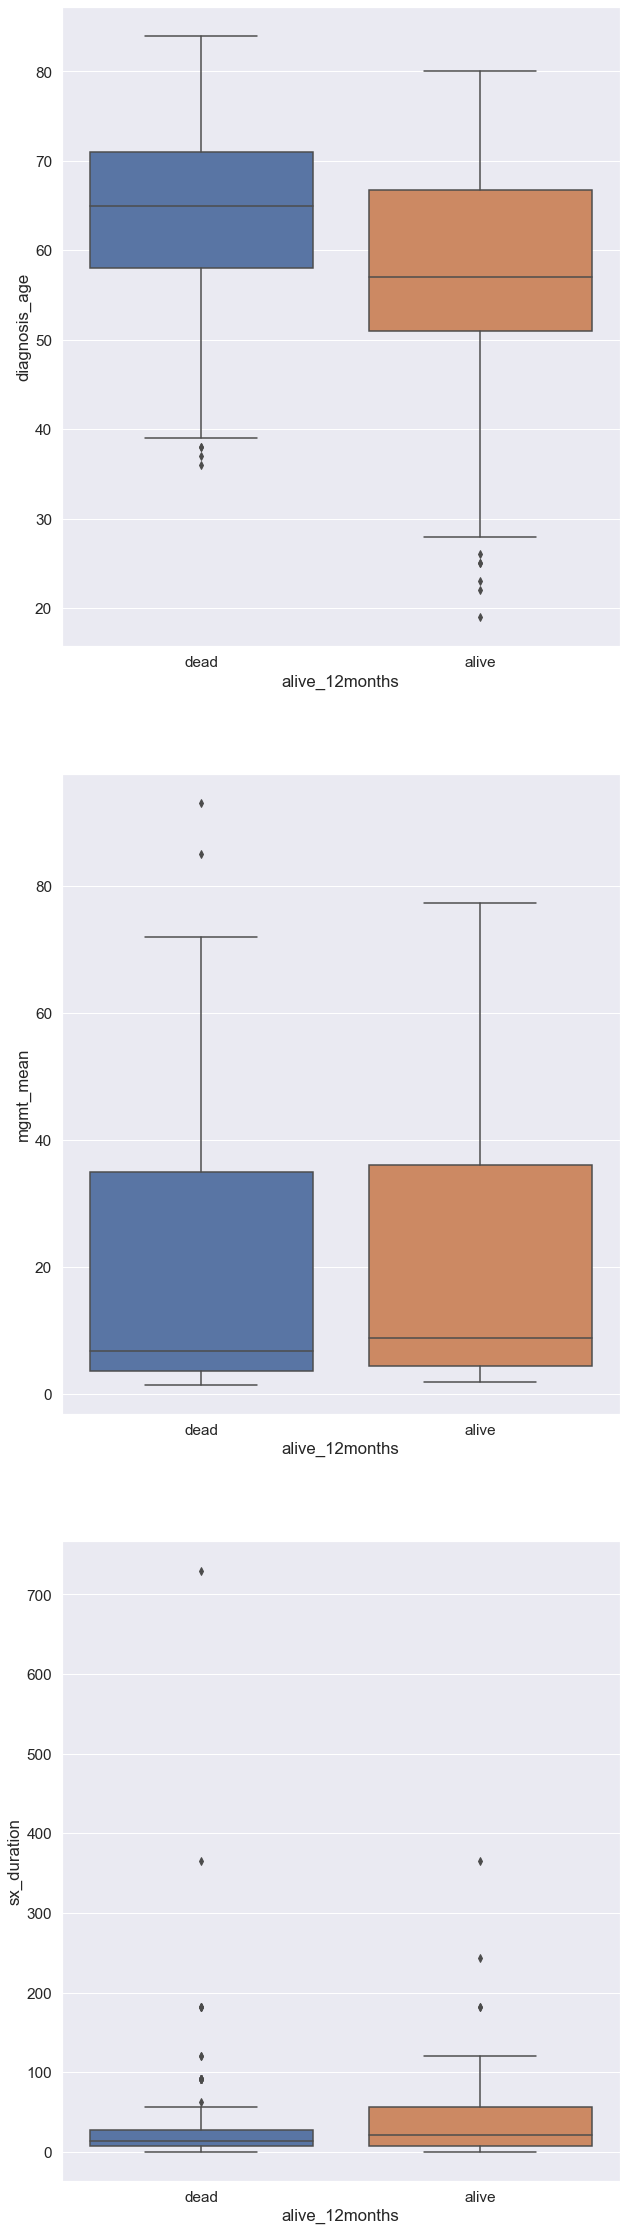

In [159]:
fig, axs = plt.subplots(len(numerical), figsize=(10,40))
for i, c in enumerate(numerical):
    sns.boxplot(x='alive_12months', y=c, data=df2, ax=axs[i])
plt.show()

There looks to be a few outliers represented in the data particularly in `sx_duration`, we will need to remove these as they can negatively impact our Logistic Regression model.

We can use the **Z-Score** to grab these data points and remove them.
> The *Z-Score* is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

We can calulate the Z-score then re-scale and center the data and look for data points which are too far from zero. These data points can then be treated as the outliers. In most cases a threshold of 3 is used.

In [277]:
import scipy.stats as stats
import numpy as np

z = np.abs(stats.zscore(df[numerical]))
threshold = 3
print(np.where(z > 3))

(array([ 58,  88, 135, 165, 242, 257, 270, 281, 285, 293, 294]), array([1, 2, 1, 2, 0, 2, 2, 0, 0, 0, 0]))


Don’t be confused by the results. The first array contains the list of row numbers and second array respective column numbers, which mean `z[58][1]` have a Z-score higher than 3.

In [278]:
z[58][1]

3.231103406929158

In [279]:
list(np.where(z > 3)[0])

[58, 88, 135, 165, 242, 257, 270, 281, 285, 293, 294]

In [280]:
df_o = df.copy()
df_o = df_o.drop(df.iloc[np.where(z > 3)[0]].index)

In [281]:
f"Original data shape {df_cat.shape} vs omitted data shape {df_o.shape}"

'Original data shape (304, 45) vs omitted data shape (293, 18)'

Box plots use the **interquartile range (IQR)** to display data and outliers.
> The **interquartile range (IQR)**, also called the **midspread** or **middle 50%**, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, *IQR = Q3 − Q1*.

It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.

In [282]:
Q1 = df[numerical].quantile(0.25)
Q3 = df[numerical].quantile(0.75)
IQR = Q3 - Q1
IQR

diagnosis_age    15.0
mgmt_mean        32.0
sx_duration      35.0
dtype: float64

As we now have the IQR scores, it's time to get our outliers. The below code will give an output with some true and false values. The data point where we have False means these values are valid whereas True indicates presence of an outlier.

In [283]:
IQR_o = (df[numerical] < (Q1 - 1.5 * IQR)) |(df[numerical] > (Q3 + 1.5 * IQR))
IQR_o.head()

,diagnosis_age,mgmt_mean,sx_duration
8,False,False,False
9,False,False,False
11,False,False,False
13,False,False,False
14,False,False,False


Now we can use several functions here to check if there is `.any()` row that contains a `True` boolean. And then we can filter the list for only the `True` outliers.

In [284]:
np.where(IQR_o.any('columns'))[0]

array([ 33,  35,  55,  58,  88, 135, 165, 167, 179, 197, 207, 226, 234,
       242, 257, 260, 267, 270, 276, 281, 285, 291, 293, 294, 296])

In [285]:
df_o2 = df.copy()
df_o2 = df_o2.drop(df.iloc[np.where(IQR_o.any('columns'))[0]].index)

In [286]:
f"Original data shape {df_cat.shape} vs omitted data shape {df_o2.shape}"

'Original data shape (304, 45) vs omitted data shape (279, 18)'

As you can see using the IQR omitted 14 extra patients than our Z-score. 

To summarize, bad data or wrong calculation can be identified as Outliers and should be dropped. However if the data represents true outliers of the population you might want correct them instead. 

For example: 5 people get salary of 10K, 20K, 30K, 40K and 50K and suddenly one person starts getting a salary of 100K. Consider this situation as the employer, the new salary update might be seen as biased and you might need to increase other employee’s salary too, to keep the balance. So, there can be multiple reasons you want to understand and correct the outliers.

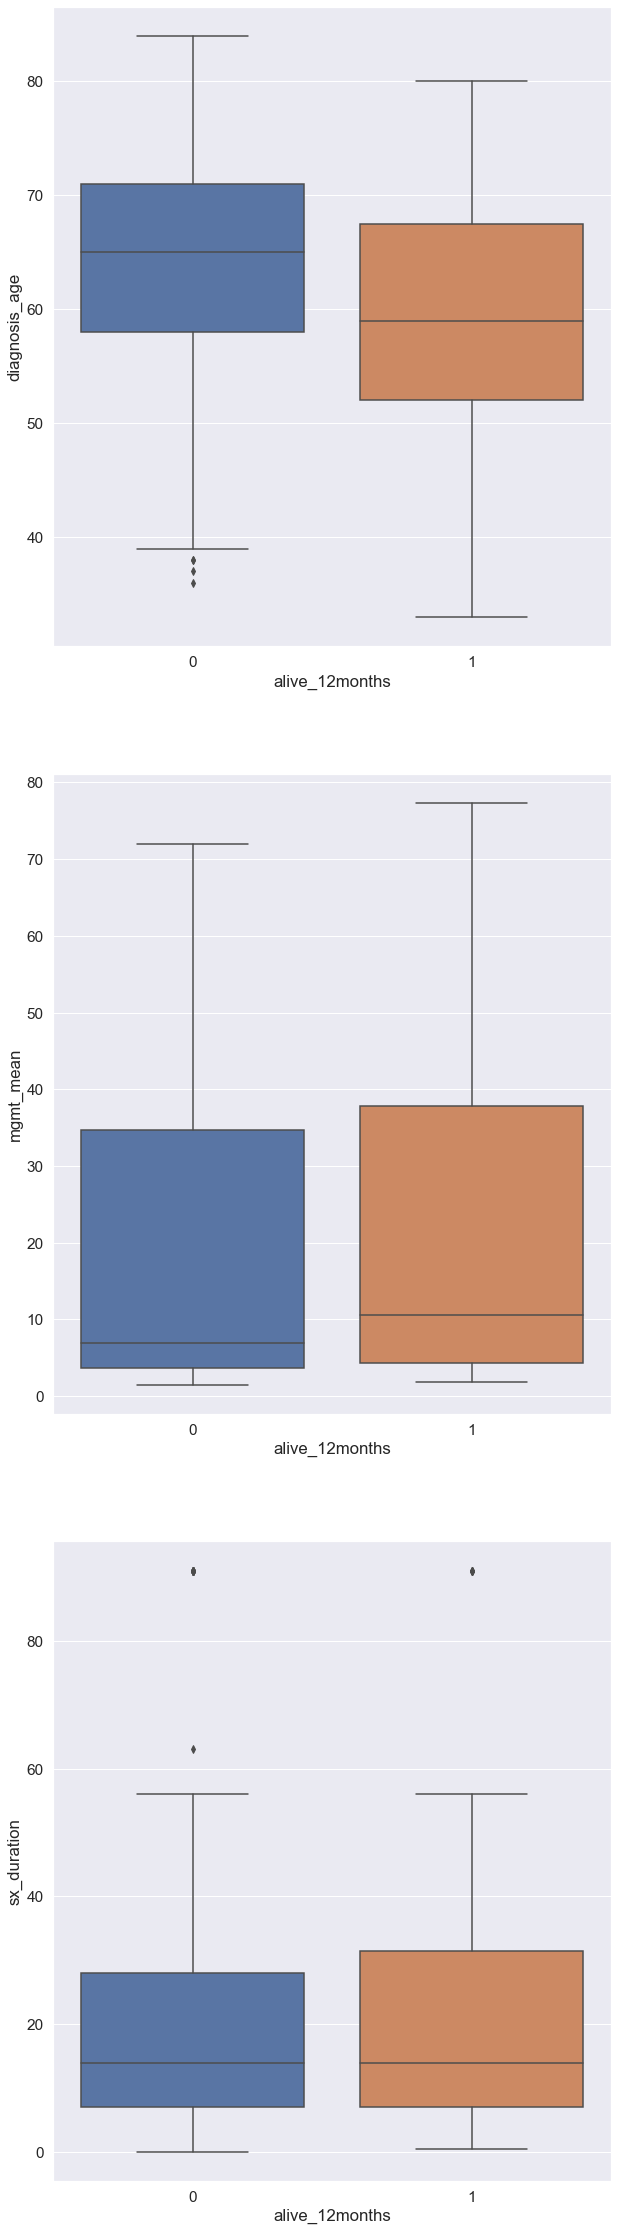

In [287]:
fig, axs = plt.subplots(len(numerical), figsize=(10,40))
for i, c in enumerate(numerical):
    sns.boxplot(x='alive_12months', y=c, data=df_o2, ax=axs[i])
plt.show()

As you can see now the box plots still show outliers, but the values are not so far away from the rest of the values and can be kept and used in the analysis.

# Logisitic Regression Model
The assumptions have been checked, and the data is good to run.

From here, it's straightforward and plugging in the desired model into the formula. For the categorical variables we can use the dummy variables created to look at multicollinearity or by using the `C(variable)`. 

If using the dummy variables, be sure to not include 1 of the groups to avoid the Dummy Variable Trap. The group dropped is then considered the reference group for the other dummy variables that came from the same original variable. Most commonly, the highest ranked group is dropped. Using the `C(variable)` method automatically does this.

The general structure of the formula is `DV ~ IV1 + IV2 + IVn`

In [288]:
df_o2.columns

Index(['sex', 'diagnosis_age', 'days_survived', 'dead', 'treatment',
       'tumor_side', 'tumor_location', 'idh_status', 'mgmt_mean', 'ps_preop',
       'ps_postop', 'sx_duration', 'chemo', 'radiotherapy', 'sx_main',
       'alive_6months', 'alive_12months', 'alive_18months'],
      dtype='object')

In [306]:
# Needed to run the logistic regression
import statsmodels.formula.api as smf

model = smf.logit("""alive_12months ~ 
                  sex +
                  diagnosis_age +
                  C(treatment) +
                  C(tumor_side) +
                  C(tumor_location) +
                  idh_status +
                  sx_duration +
                  chemo +
                  C(radiotherapy) +
                  C(sx_main)
                  """, data=df_o2).fit()
model.summary()

         Current function value: 0.403544
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         alive_12months   No. Observations:                  279
Model:                          Logit   Df Residuals:                      255
Method:                           MLE   Df Model:                           23
Date:                Fri, 01 May 2020   Pseudo R-squ.:                  0.3497
Time:                        04:37:58   Log-Likelihood:                -112.59
converged:                      False   LL-Null:                       -173.13
Covariance Type:            nonrobust   LLR p-value:                 2.645e-15
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                49.0544    1.4e+07   3.49e-06      1.000   -2.75e+07    2.75e+07
sex[T.male]                              -0.1458      0.354     -0.411      0.681      -0.840       0.549
C(treatment)[T.Debulking]                -0.1514      0.597     -0.254      0.800      -1.321       1.018
C(treatment)[T.Gross Total Resection]     1.1406      0.494      2.307      0.021       0.172       2.110
C(treatment)[T.Subtotal Resection]        0.1844      0.586      0.315      0.753      -0.963       1.332
C(tumor_side)[T.left]                   -48.5424    1.4e+07  -3.46e-06      1.000   -2.75e+07    2.75e+07
C(tumor_side)[T.right]                  -48.1518    1.4e+07  -3.43e-06      1.000   -2.75e+07    2.75e+07
C(tumor_location)[T.Corpus callosum]    -79.2420   1.49e+07   -5.3e-06      1.000   -2.93e+07    2.93e+07
C(tumor_location)[T.External capsule]   -47.2060    1.4e+07  -3.36e-06      1.000   -2.75e+07    2.75e+07
C(tumor_location)[T.Frontal lobe]        -0.6518      1.754     -0.372      0.710      -4.090       2.787
C(tumor_location)[T.Insula]             -28.9522   4.11e+05  -7.05e-05      1.000   -8.05e+05    8.05e+05
C(tumor_location)[T.Occipital lobe]      -0.8237      1.847     -0.446      0.656      -4.444       2.797
C(tumor_location)[T.Parietal lobe]       -0.8142      1.767     -0.461      0.645      -4.277       2.649
C(tumor_location)[T.Temporal lobe]       -1.6035      1.763     -0.910      0.363      -5.058       1.851
C(tumor_location)[T.Thalamus]           -18.2220   3477.432     -0.005      0.996   -6833.863    6797.419
C(radiotherapy)[T.30]                    -0.4852      0.829     -0.585      0.559      -2.111       1.140
C(radiotherapy)[T.40]                     2.1404      0.849      2.522      0.012       0.477       3.804
C(radiotherapy)[T.60]                    23.3091   1.62e+04      0.001      0.999   -3.18e+04    3.19e+04
C(sx_main)[T.headache]                    0.7739      0.457      1.692      0.091      -0.123       1.670
C(sx_main)[T.seizure]                     0.4866      0.465      1.046      0.295      -0.425       1.398
diagnosis_age                            -0.0465      0.019     -2.422      0.015      -0.084      -0.009
idh_status                               -0.5376      1.110     -0.484      0.628      -2.714       1.639
sx_duration                               0.0054      0.007      0.808      0.419      -0.008       0.019
chemo                                   -20.7008   1.62e+04     -0.001      0.999   -3.19e+04    3.18e+04
=========================================================================================================
"""

## Interpreting Logistic Regression Models
The model summary shows the coefficients, standard error, the associated z-score, and the 95% confidence intervals. We interpret the results as follows, the overall model is significant indicated by a LLR p-value < 0.05 (1.591e-32) which allows us to look at the rest of the results.

Not all the IVs have a significant effect on the log odds of having CAD as indicated by the `P>|z| < 0.05`.

In [307]:
def summary_to_df(model):
    results = pd.DataFrame(model.summary().tables[1])
    cols = results.iloc[0].astype(str)
    cols[0] = "DV"
    results.columns = cols
    results = results.drop(0)
    results = results.set_index('DV')
    results = results.astype(str).astype(float)
    return results

results = summary_to_df(model)
results[results['P>|z|'] < 0.05]

,coef,std err,z,P>|z|,[0.025,0.975]
DV,,,,,,
C(treatment)[T.Gross Total Resection],1.1406,0.494,2.307,0.021,0.172,2.110
C(radiotherapy)[T.40],2.1404,0.849,2.522,0.012,0.477,3.804
diagnosis_age,-0.0465,0.019,-2.422,0.015,-0.084,-0.009


### Numeric Variables
Interpreting continuous variables is not very different from interpreting them in a linear regression model. For every one unit increase in the patients `diagnosis_age`, the log odds of surviving 12 months decreases by `-0.0465`.

When comparing binary varibles such as sex (0 = male; 1 = female) you simply compare the two values with each other. So increasing the sex value by one unit is actually the female sex. Sex has no statistical significance on this model.

### Categorical Variables
The categorical variables have a different interpretation. Since Rank 1 was dropped from the analysis, it is the comparison group and plays an important role in interpreting the other categories.

**treatment type:**
- biopsy
- debulking
- gross total resection
- subtotal resection

For example, if a patient had a `gross total resection` compared to `biopsy` (Intercept), there is a `1.1406` increase in the log odds of surviving 12 months.

## Taking Logistic Regression a Step Further
Interpreting the log odds is not very straightforward when thinking about it's effects. An easier way to interpret the findings is by converting the coefficients of the logisitic regression model into odd ratios. This can be done by getting the exponent of the coefficient value.

In [308]:
model_odds = pd.DataFrame(np.exp(model.params), columns=['OR'])
model_odds['z-value'] = model.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(model.conf_int())
model_odds

/Users/stefan/.local/share/virtualenvs/jupyter-_G5N12kM/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


,OR,z-value,2.5%,97.5%
Intercept,2.013942e+21,0.999997,0.000000,inf
sex[T.male],8.643464e-01,0.680850,0.431508,1.731357
C(treatment)[T.Debulking],8.595357e-01,0.799768,0.266878,2.768313
C(treatment)[T.Gross Total Resection],3.128573e+00,0.021054,1.187180,8.244725
C(treatment)[T.Subtotal Resection],1.202483e+00,0.752848,0.381626,3.788962
C(tumor_side)[T.left],8.285203e-22,0.999997,0.000000,inf
C(tumor_side)[T.right],1.224384e-21,0.999997,0.000000,inf
C(tumor_location)[T.Corpus callosum],3.851708e-35,0.999996,0.000000,inf
C(tumor_location)[T.External capsule],3.152936e-21,0.999997,0.000000,inf
C(tumor_location)[T.Frontal lobe],5.210929e-01,0.710227,0.016735,16.226032


Converting the logistic coefficients into odds ratios makes it easier to interpret the effects on the DV. The confidence intervals have been converted to odds as well.

### Numeric Variables
For every one unit increase in the `sx_duration` achieved the odds of surviving 12 months increases by a factor of `1.005`. The closer to `1.0` the less impact the varible has.

### Categorical Variables
Still interpreting the results in comparison to the intercept group.

**treatment type:**
- biopsy
- debulking
- gross total resection
- subtotal resection

Patients that had a `gross total resection` compared to `biopsy` (Intercept), are `3.129` more likely to survive 12 months.

When interpreting odd ratios, any value greater than 1 indicates an increase in the odds, i.e. an increase in the likelihood, of that group being in the outcome variable, and any value less than 1 indicates a decrease in the odds, i.e. an decrease in the likelihood.

## Creating a Model for Logistic Regression

We can now use the sklearn library to apply the logistic regression model to future values.
```
alive_12months ~ 
  sex +
  diagnosis_age +
  C(treatment) +
  C(tumor_side) +
  C(tumor_location) +
  idh_status +
  sx_duration +
  chemo +
  C(radiotherapy) +
  C(sx_main)
```

In [313]:
categorical = [
    'treatment',
    'tumor_side',
    'tumor_location',
    'radiotherapy',
    'sx_main'
]
df_o2_cat = df_o2[[
    'alive_12months',
    'sex', 
    'diagnosis_age', 
    'treatment', 
    'tumor_side', 
    'tumor_location', 
    'idh_status', 
    'sx_duration',
    'chemo',
    'radiotherapy',
    'sx_main'
]].copy()
for category in categorical:
    df_o2_cat[category] = df_o2_cat[category].astype('category')
df_o2_cat = pd.get_dummies(df_o2_cat)
df_o2_cat.columns = [x.lower().replace(' ', '_') for x in df_o2_cat.columns.tolist()]
df_o2_cat.head()

,alive_12months,diagnosis_age,idh_status,sx_duration,chemo,sex_female,sex_male,treatment_biopsy,treatment_debulking,treatment_gross_total_resection,...,tumor_location_parietal_lobe,tumor_location_temporal_lobe,tumor_location_thalamus,radiotherapy_0,radiotherapy_30,radiotherapy_40,radiotherapy_60,sx_main_deficit,sx_main_headache,sx_main_seizure
8,0,75,0,42.0,0,0,1,0,1,0,...,0,1,0,1,0,0,0,1,0,0
9,0,63,0,21.0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
11,0,84,0,1.0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
13,0,54,0,14.0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
14,0,62,0,14.0,0,1,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0


In [315]:
from sklearn.model_selection import train_test_split

y = df_o2_cat['alive_12months'].values
np.place(y, y>0, 1)
x = df_o2_cat.drop('alive_12months', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state=0)
print(y_test)
x_test.head()

[1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1
 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0]


,diagnosis_age,idh_status,sx_duration,chemo,sex_female,sex_male,treatment_biopsy,treatment_debulking,treatment_gross_total_resection,treatment_subtotal_resection,...,tumor_location_parietal_lobe,tumor_location_temporal_lobe,tumor_location_thalamus,radiotherapy_0,radiotherapy_30,radiotherapy_40,radiotherapy_60,sx_main_deficit,sx_main_headache,sx_main_seizure
397,56,0,1.0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,1,1,0,0
408,74,0,28.0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
443,50,0,14.0,1,0,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,1
35,78,0,14.0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
123,51,0,56.0,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0


In [316]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs')
lr.fit(x_train,y_train)
print("Train Data Accuracy {:.2f}%".format(lr.score(x_train,y_train)*100))
print("Test Data Accuracy {:.2f}%".format(lr.score(x_test,y_test)*100))

Train Data Accuracy 77.58%
Test Data Accuracy 83.93%


In [332]:
import joblib
joblib.dump(lr, 'model.pkl')
model_columns = list(x.columns)
joblib.dump(model_columns, 'model_columns.pkl')
print(model_columns)

['diagnosis_age', 'idh_status', 'sx_duration', 'chemo', 'sex_female', 'sex_male', 'treatment_biopsy', 'treatment_debulking', 'treatment_gross_total_resection', 'treatment_subtotal_resection', 'tumor_side_both', 'tumor_side_left', 'tumor_side_right', 'tumor_location_cerebellum', 'tumor_location_corpus_callosum', 'tumor_location_external_capsule', 'tumor_location_frontal_lobe', 'tumor_location_insula', 'tumor_location_occipital_lobe', 'tumor_location_parietal_lobe', 'tumor_location_temporal_lobe', 'tumor_location_thalamus', 'radiotherapy_0', 'radiotherapy_30', 'radiotherapy_40', 'radiotherapy_60', 'sx_main_deficit', 'sx_main_headache', 'sx_main_seizure']


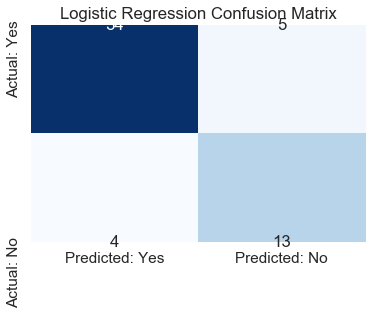

In [317]:
from sklearn.metrics import confusion_matrix

y_head = lr.predict(x_test)
cm_lr = confusion_matrix(y_test,y_head)
cm_df = pd.DataFrame(cm_lr, index=['Actual: Yes', 'Actual: No'], columns=['Predicted: Yes', 'Predicted: No'])
g = sns.heatmap(cm_df,
                annot=True,
                cmap="Blues",
                fmt="d",
                cbar=False,
               )
g.set_title("Logistic Regression Confusion Matrix")
plt.show()

\begin{align}
Sensitivity = \frac{True\:Positives}{True\:Positives + False\:Negatives}
\end{align}

\begin{align}
Specificity = \frac{True\:Negatives}{True\:Negatives + False\:Positives}
\end{align}

In [318]:
total=sum(sum(cm_lr))

sensitivity = cm_lr[0,0]/(cm_lr[0,0]+cm_lr[1,0])
print(f'Sensitivity : {sensitivity*100:.2f}%')

specificity = cm_lr[1,1]/(cm_lr[1,1]+cm_lr[0,1])
print(f'Specificity : {specificity*100:.2f}%')

Sensitivity : 89.47%
Specificity : 72.22%


That seems reasonable. Let's also check with a **[Receiver Operator Curve (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)**,

In [319]:
y_predict = lr.predict(x_test)
y_pred_quant = lr.predict_proba(x_test)[:, 1]
y_pred_bin = lr.predict(x_test)

In [320]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

In [321]:
roc = pd.DataFrame([fpr, tpr]).T
roc.columns = ['fpr', 'tpr']

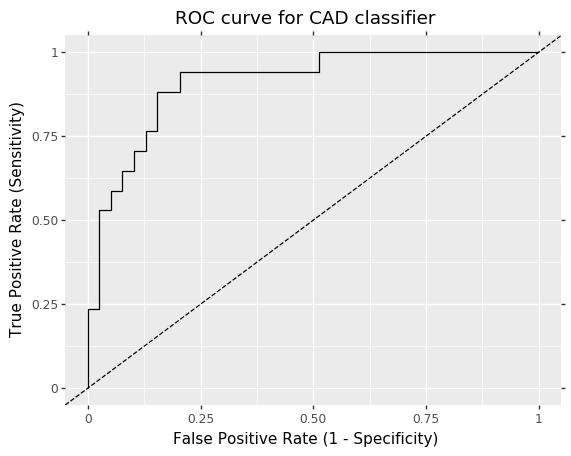

In [322]:
g = (ggplot(roc, aes(x='fpr', y='tpr'))
     + geom_line()
     + geom_abline(intercept=0, linetype='--')
     + labs(
         title='ROC curve for CAD classifier',
         x='False Positive Rate (1 - Specificity)',
         y='True Positive Rate (Sensitivity)'
     )
    ).draw()
g.show()

Another common metric is the **Area Under the Curve**, or **AUC**. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

- 0.90 - 1.00 = excellent
- 0.80 - 0.90 = good
- 0.70 - 0.80 = fair
- 0.60 - 0.70 = poor
- 0.50 - 0.60 = fail

Let's see what the above ROC gives us:

In [323]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.9110105580693816

# Explaning the Model

Now let's see what the model gives us from the ML explainability tools.

**Permutation importance** is the first tool for understanding a machine-learning model, and involves shuffling individual variables in the validation data (after a model has been fit), and seeing the effect on accuracy. Learn more [here](https://www.kaggle.com/dansbecker/permutation-importance).

In [325]:
from eli5 import show_weights
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(lr, random_state=1).fit(x_test, y_test)
show_weights(perm, 
             feature_names=x_test.columns.tolist())

/Users/stefan/.local/share/virtualenvs/jupyter-_G5N12kM/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/stefan/.local/share/virtualenvs/jupyter-_G5N12kM/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.0786 ± 0.0484,treatment_gross_total_resection
0.0536 ± 0.0782,radiotherapy_60
0.0321 ± 0.0474,radiotherapy_30
0.0143 ± 0.0143,tumor_side_left
0.0107 ± 0.0175,tumor_location_frontal_lobe
0.0036 ± 0.0416,treatment_biopsy
0.0036 ± 0.0474,radiotherapy_0
0.0036 ± 0.0143,tumor_location_thalamus
0.0000 ± 0.0505,diagnosis_age
0.0000 ± 0.0505,treatment_debulking


You can see that weighting is given primarily to the categorical variables. As you would expect the highest level of therapy increases your probability of surviving >12 months

Let's take a closer look using a **Partial Dependence Plot** (learn more [here](https://www.kaggle.com/dansbecker/partial-plots)). These plots vary a single variable in a single row across a range of values and see what effect it has on the outcome. It does this for several rows and plots the average effect.

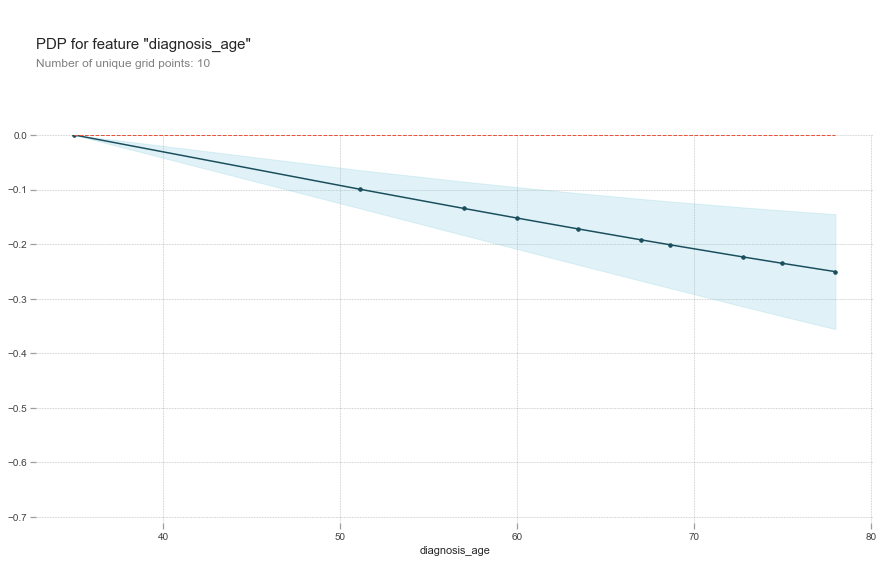

In [328]:
from pdpbox.pdp import pdp_isolate, pdp_plot

base_features = x_train.columns.tolist()

feat_name = 'diagnosis_age'
pdp_dist = pdp_isolate(model=lr, 
                       dataset=x_test, 
                       model_features=base_features, 
                       feature=feat_name)

pdp_plot(pdp_dist, feat_name)
plt.show()

So, we can see that as the diagnosis age *increases*, the probability of surviving >12 months *decreases*.